- https://github.com/AstraZeneca/skywalkR-graph-features

> KR4SL: knowledge graph reasoning for explainable prediction of synthetic lethality 
> - https://doi.org/10.1093/bioinformatics/btad261

- https://github.com/mims-harvard/PrimeKG#dataloader-therapeutics-data-commons

- https://tdcommons.ai/multi_pred_tasks/ppi/

___

### Load ...

In [1]:
import numpy as np 
import pandas as pd
import anndata as ad
import screenpro

from screenpro.load import loadScreenProcessingData, read_adata_pkl

import sys
sys.path.append("/data_gilbert/home/aarab/FunGI")
from search import *

In [2]:
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm
from matplotlib import rcParams

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

___

In [3]:
import igraph as ig

In [134]:
# def convert_graph_to_dataframe(G):
#     # https://igraph.discourse.group/t/convert-graph-object-to-dataframe/575
#     node_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()})
#     edge_df = pd.DataFrame({attr: G.es[attr] for attr in G.edge_attributes()})
    
#     return edge_df, node_df

In [4]:
help(filter_graph_by_weight)

Help on function filter_graph_by_weight in module search:

filter_graph_by_weight(G, weight_thr, side, verbose=True)
    subset graph by weight threshold



In [5]:
help(run_bfs)

Help on function run_bfs in module search:

run_bfs(graph, node, distance=1)
    Run BFS – Breadth-First Traversal (or Search)
    This function is running BFS algorithm to create a subgraph for given 1) `igraph` object, 2) node id, and 3) distance from the node.
    The subgraph includes all nodes with certain distance (defualt 1) from the given node.



In [6]:
def build_graph(df,verbose=True):

    out = ig.Graph.TupleList(df.itertuples(index=False), directed=False, weights=True)

    if verbose: get_graph_features(out)

    return out

In [81]:
def filter_graph_by_nodes_BFS(G, nodes, max_distance=1, verbose=True):
    """filter graph `G` by running BFS for given nodes
    """
    bfs = []
    for node in nodes:
        for distance in range(1, max_distance + 1):
            bfs = bfs + run_bfs(G, node, distance=distance)
    
    outG = G.vs.select(name_in=bfs + nodes).subgraph()
    
    if verbose: get_graph_features(outG)
    
    return outG

In [8]:
def plot_graph(G, geneset=None, geneset2=None, layout="kk", b1=500, b2=500):
    """visualising graph data
    """
    G.vs["color"] = ["lightgray" for vertex in G.vs] 

    if geneset: 
        for gene in geneset:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = 'yellow'
            
    if geneset2: 
        for gene in geneset2:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = "lightblue"

    return ig.plot(
        G,
        layout=G.layout(layout),
        vertex_label=G.vs["name"],
        vertex_color=G.vs["color"],
        vertex_label_size=6, 
        vertex_size=35,
        edge_arrow_size = 0.5,
        edge_arrow_width = 2,
        bbox=(b1, b2), margin=60,
    )

___

In [9]:
%load_ext rpy2.ipython

https://users.dimi.uniud.it/~massimo.franceschet/R/communities.html

https://kateto.net/netscix2016.html

In [10]:
%%R
library(igraph)
library(tidyverse)

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


___

### Drug KG

In [1]:
!mkdir -p datasets

In [2]:
import pandas as pd

from tdc.multi_pred import DrugRes
from tdc.resource import PrimeKG

from copy import copy


class PrimeExplorer:

    """PrimeKG Explorer
    """
    def __init__(self, df=None,primekg=None):
        """load the subgraph of PrimeKG"""
        if df:
            self.df = df
        else:
            self.df = primekg.df
    
    def copy(self):
        return copy(self)
    
    def run_query(self, query):
        """build subgraph using given query"""
        self.df_raw = self.df
        self.df = self.df.query(query)
    
    def get_nodes_by_source(self, source):
        # extract x nodes
        x_df = self.df.query(
            f"x_source == '{source}' | y_source == '{source}'"
        )[[col for col in self.df.columns if col.startswith("x_")]]

        for col in x_df.columns:
            x_df = x_df.rename(columns={col: col[2:]})

        # extract y nodes
        y_df = self.df.query(
            f"x_source == '{source}' | y_source == '{source}'"
        )[[col for col in self.df.columns if col.startswith("y_")]]
        for col in y_df.columns:
            y_df = y_df.rename(columns={col: col[2:]})
        # merge x and y nodes and keep only unique nodes
        out = pd.concat([x_df, y_df], axis=0).query(f'source == "{source}"').drop_duplicates().reset_index(drop=True)

        return out

In [3]:
# Drug Response Prediction Task Overview
# Y is the log normalized IC50. This is the version 2 of GDSC, which uses improved experimental procedures.

# https://tdcommons.ai/multi_pred_tasks/drugres/

In [4]:
GDSC1 = DrugRes(name = 'GDSC1', path = './datasets/GDSC1')
GDSC2 = DrugRes(name = 'GDSC2', path = './datasets/GDSC2')

primekg = PrimeExplorer(primekg = PrimeKG(path = './datasets/PrimeKG'))

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...


### DAC - gene

### DAC + X Drug

In [50]:
primekg_drug_target = primekg.copy()

primekg_drug_target.run_query(query='relation == "drug_protein" & display_relation == "target"')

In [7]:
durgs = primekg.get_nodes_by_source('DrugBank')

In [8]:
durgs

,id,type,name,source
0,DB09130,drug,Copper,DrugBank
1,DB09140,drug,Oxygen,DrugBank
2,DB00180,drug,Flunisolide,DrugBank
3,DB00240,drug,Alclometasone,DrugBank
4,DB00253,drug,Medrysone,DrugBank
...,...,...,...,...
7952,DB01486,drug,Cathine,DrugBank
7953,DB11104,drug,Sulfur hexafluoride,DrugBank
7954,DB00639,drug,Butoconazole,DrugBank
7955,DB00538,drug,Gadoversetamide,DrugBank


In [9]:
primekg_dac_synergy = primekg.copy()

primekg_dac_synergy.run_query('(x_name == "Decitabine" | y_name == "Decitabine")&(display_relation == "synergistic interaction")')

In [10]:
primekg_dac_synergy_drug_names = primekg_dac_synergy.get_nodes_by_source(source='DrugBank').name.to_list()

___

In [11]:
target_genes = [
    "PMPCA","RNF126","SLC7A6","DHODH","ZNF777","SQLE","MYBBP1A","RBM14-RBM4","INTS5","INO80D",
    'BCL2'
] 
# + ['DNMT1']

In [13]:
target_genes

['PMPCA',
 'RNF126',
 'SLC7A6',
 'DHODH',
 'ZNF777',
 'SQLE',
 'MYBBP1A',
 'RBM14-RBM4',
 'INTS5',
 'INO80D']

In [14]:
primekg_drugs_for_combo = primekg_drug_target.copy()
primekg_drugs_for_combo.run_query(f'x_name in {target_genes} | y_name in {target_genes}')

In [15]:
primekg_drugs_for_combo.get_nodes_by_source('NCBI')

,id,type,name,source
0,1723,gene/protein,DHODH,NCBI
1,6713,gene/protein,SQLE,NCBI


In [20]:
primekg_dac_synergy_drugs_for_combo = primekg_drugs_for_combo.copy()
primekg_dac_synergy_drugs_for_combo.run_query(f'x_name in {primekg_dac_synergy_drug_names} | y_name in {primekg_dac_synergy_drug_names}')

In [25]:
primekg_dac_synergy_drugs_for_combo_list = primekg_dac_synergy_drugs_for_combo.get_nodes_by_source(source='DrugBank').name.to_list()

### 
prep a table for paper...

In [26]:
table_0 = primekg_drugs_for_combo.df.query('x_type=="drug"')#.set_index(['y_name','x_id'])[['x_name']]

table_0['dac_synergy'] = table_0.x_name.isin(primekg_dac_synergy_drugs_for_combo_list)
table_0.sort_values(['y_name','dac_synergy'],ascending=False,inplace=True)

In [85]:
table_1 = table_0[['y_name','x_id','x_name','dac_synergy']].rename(columns={'y_name':'target','x_id':'DrugBank','x_name':'Drug full name'}).set_index(['target','DrugBank'])

In [86]:
drug_targets = {}

for drug in table_1.reset_index().DrugBank:
    drug_kg = primekg_drug_target.copy()
    drug_kg.run_query(f'x_id == "{drug}" | y_id == "{drug}"')
    
    drug_targets[drug] = ','.join(drug_kg.get_nodes_by_source('NCBI').name.to_list())

table_1['drug_targets'] = drug_targets.values()

del drug_targets

In [ ]:
table_1

Drug full name  \
target DrugBank                                                      
SQLE   DB00735                                           Naftifine   
       DB00857                                         Terbinafine   
       DB01091                                          Butenafine   
       DB08846                                        Ellagic acid   
DHODH  DB01097                                         Leflunomide   
       DB03523                                           Brequinar   
       DB08880                                       Teriflunomide   
       DB01117                                          Atovaquone   
       DB02262                                         Orotic acid   
       DB02613                         Capric dimethyl amine oxide   
       DB03247                               Flavin mononucleotide   
       DB03480                                    Brequinar Analog   
       DB04147                        Dodecyldimethylamine N-oxide   
       DB04281   2-[4-(4-Chlorophenyl)Cyclohexylidene]-3,4-Dihy...   
       DB04583   5-Carbamoyl-1,1':4',1''-terphenyl-3-carboxylic...   
       DB05125                                             SC12267   
       DB06481                                           Manitimus   
       DB07443   (2Z)-N-biphenyl-4-yl-2-cyano-3-hydroxybut-2-en...   
       DB07559   (2Z)-2-cyano-N-(2,2'-dichlorobiphenyl-4-yl)-3-...   
       DB07561   (2Z)-2-cyano-N-(3'-ethoxybiphenyl-4-yl)-3-hydr...   
       DB07646                   UNDECYLAMINE-N,N-DIMETHYL-N-OXIDE   
       DB07975   2-({[3,5-DIFLUORO-3'-(TRIFLUOROMETHOXY)BIPHENY...   
       DB07976   3-{[(3-FLUORO-3'-METHOXYBIPHENYL-4-YL)AMINO]CA...   
       DB07977   3-({[3,5-DIFLUORO-3'-(TRIFLUOROMETHOXY)BIPHENY...   
       DB07978   2-({[2,3,5,6-TETRAFLUORO-3'-(TRIFLUOROMETHOXY)...   
       DB08006   N-anthracen-2-yl-5-methyl[1,2,4]triazolo[1,5-a...   
       DB08008   5-methyl-N-[4-(trifluoromethyl)phenyl][1,2,4]t...   
       DB08169   (2Z)-N-biphenyl-4-yl-2-cyano-3-cyclopropyl-3-h...   
       DB08172   (2Z)-N-(3-chloro-2'-methoxybiphenyl-4-yl)-2-cy...   
       DB08249                   3,6,9,12,15-PENTAOXATRICOSAN-1-OL   

                 dac_synergy  \
target DrugBank                
SQLE   DB00735         False   
       DB00857         False   
       DB01091         False   
       DB08846         False   
DHODH  DB01097          True   
       DB03523          True   
       DB08880          True   
       DB01117         False   
       DB02262         False   
       DB02613         False   
       DB03247         False   
       DB03480         False   
       DB04147         False   
       DB04281         False   
       DB04583         False   
       DB05125         False   
       DB06481         False   
       DB07443         False   
       DB07559         False   
       DB07561         False   
       DB07646         False   
       DB07975         False   
       DB07976         False   
       DB07977         False   
       DB07978         False   
       DB08006         False   
       DB08008         False   
       DB08169         False   
       DB08172         False   
       DB08249         False   

                                                      drug_targets  
target DrugBank                                                     
SQLE   DB00735                                                SQLE  
       DB00857                                                SQLE  
       DB01091                                                SQLE  
       DB08846   CA1,CA2,CA4,SQLE,PRKCB,PRKCA,CSNK2A1,SYK,CA12,...  
DHODH  DB01097                                     DHODH,PTK2B,AHR  
       DB03523                                               DHODH  
       DB08880                                               DHODH  
       DB01117                                               DHODH  
       DB02262                                               DHODH  
       DB02613             

### Literature search

In [72]:
table_1.to_excel('DAC_combo_candidates.xlsx')

https://clue.io/repurposing-app
    
- leflunomide	Launched
- brequinar	Phase 2
- teriflunomide	Launched
- butenafine	Launched
- terbinafine	Launched
- atovaquone	Launched
  - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9954468/
> We show, in a clinical pilot study, that combining atovaquone with standard AML induction chemotherapy is feasible and safe in children.
- manitimus	Preclinical
- naftifine	Launched

In [61]:
cell_lines = ['HL-60','MOLM-13']

___

In [62]:
# GDSC1.get_data().query(f"Drug_ID in {primekg_dac_synergy_drugs_for_combo_list} &  `Cell Line_ID` in {cell_lines}").sort_values('Y',ascending=False)

In [70]:
GDSC2.get_data().query(f"Drug_ID in {primekg_drugs_for_combo.get_nodes_by_source('DrugBank').name.to_list()} &  `Cell Line_ID` in {cell_lines}").sort_values('Y',ascending=False)

,Drug_ID,Drug,Cell Line_ID,Cell Line,Y
47559,Leflunomide,CC1=C(C=NO1)C(=O)NC2=CC=C(C=C2)C(F)(F)F,HL-60,"[3.3509853404098497, 2.99626031382298, 9.94965...",4.818404
48115,Leflunomide,CC1=C(C=NO1)C(=O)NC2=CC=C(C=C2)C(F)(F)F,MOLM-13,"[3.4406201832575, 2.92685171367912, 9.11426679...",2.624924


### Drug -> AML

In [36]:
# `Cell Line_ID` in ["HL-60","MOLM-13"] &

In [34]:
# g = PrimeKG.to_nx()

In [35]:
# g = ig.Graph.from_networkx(g)

this is problematic – https://github.com/mims-harvard/TDC/blob/6af2a41679a0699446ad627be8051504548e86fa/tdc/resource/primekg.py#L30

In [107]:
# help(ig.Graph.TupleList)

In [177]:
g = ig.Graph.TupleList(
    data.df[['x_id','y_id','display_relation','x_type','x_name','y_type','y_name']].itertuples(index=False),
    edge_attrs=['display_relation','x_type','x_name','y_type','y_name'],
    directed=True, weights=False
)

In [178]:
get_graph_features(g)

IGRAPH DN-- 135010 8100498 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 135010
Number of edges in the graph 8100498
Is the graph directed: True
Maximum degree in the graph: 34998
Node name with Maximum degree: []


In [179]:
g_PARPi = filter_graph_by_nodes_BFS(g,['DB09074'],max_distance=2)

IGRAPH DN-- 11252 3258577 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 11252
Number of edges in the graph 3258577
Is the graph directed: True
Maximum degree in the graph: 5200
Node name with Maximum degree: ['DB00908']


In [180]:
g_PARPi_edge_df = g_PARPi.get_edge_dataframe()

___

In [181]:
d = g_PARPi_edge_df

In [182]:
%%R -i d
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

# V(g)$color <- l[V(g)$name,]
# E(g)$width <- E(g)$weight 

In [ ]:
%%R
V(g)$name

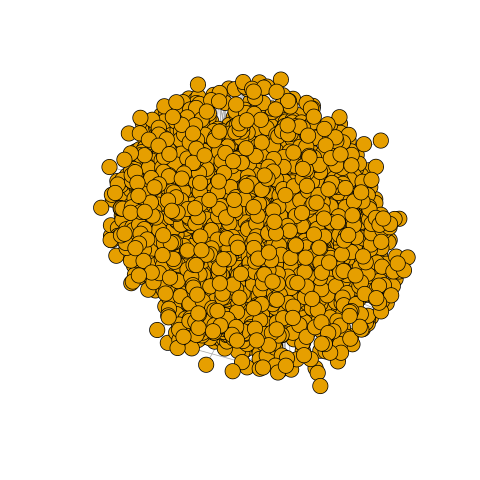

In [185]:
%%R
coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     # vertex.color =l[V(g)$name,],
     vertex.size=10,
    )

### Get phenotype scores

In [155]:
Ci_adata = read_adata_pkl('datasets/CRISPRi')
Ca_A549_adata = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562_adata = read_adata_pkl('datasets/CRISPRa_k562')

In [156]:
def get_annotated_score_df(adata,score,level,threshold):
    if level == 'transcript':
        df = adata.transcript_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').reset_index(drop=True).copy()
    
    elif level == 'gene':
        df = adata.gene_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').copy()
        
    df = screenpro.phenoScore.ann_score_df(df, ctrl_label='pseudo',threshold=threshold)
    
    return df

In [157]:
screenpro.phenoScore.ann_score_df

<function screenpro.phenoScore.ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', ctrl_label='non-targeting', threshold=10)>

In [158]:
threshold = 2

In [159]:
rho_dict = dict([
    (treat,get_annotated_score_df(Ci_adata,score,'gene',threshold = threshold).set_index('target')) for treat, score in Ci_adata.comparisons.items()
])

In [160]:
rho_df = pd.concat(dict([(treat,rho.score) for treat, rho in rho_dict.items()]),axis=1)
# rho_df = pd.concat(rho_dict,axis=1)

rho_label = pd.concat(dict([(treat,rho.label) for treat, rho in rho_dict.items()]),axis=1)

In [161]:
rho_bin = pd.DataFrame(0,index=rho_label.index,columns=rho_label.columns)

rho_bin = (rho_label.isin(['sensitivity_hit']) * -1) + (rho_label.isin(['resistance_hit']) * 1)

# rho_bin = rho_bin[~rho_bin.eq(0).sum(axis=1).eq(9)]

___

In [165]:
data.df.query('x_name == "PRDX1"')

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
2467,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,55692,gene/protein,LUC7L,NCBI
4249,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,117157,gene/protein,SH2D1B,NCBI
5540,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,23512,gene/protein,SUZ12,NCBI
10167,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,246184,gene/protein,CDC26,NCBI
28299,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,9585,gene/protein,KIF20B,NCBI
...,...,...,...,...,...,...,...,...,...,...
5729251,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14487,drug,Zinc acetate,DrugBank
5729252,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14533,drug,Zinc chloride,DrugBank
5729253,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14548,drug,"Zinc sulfate, unspecified form",DrugBank
6496314,exposure_protein,interacts with,5052,gene/protein,PRDX1,NCBI,D001151,exposure,Arsenic,CTD


In [288]:
get_graph_features(g_PARPi)

IGRAPH DN-- 11252 3258577 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 11252
Number of edges in the graph 3258577
Is the graph directed: True
Maximum degree in the graph: 5200
Node name with Maximum degree: ['DB00908']


In [285]:
g_PARPi_prdx1 = filter_graph_by_nodes_BFS(g_PARPi,['5052'],max_distance=2)

IGRAPH DN-- 4587 2223894 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 4587
Number of edges in the graph 2223894
Is the graph directed: True
Maximum degree in the graph: 4451
Node name with Maximum degree: ['DB00363']


In [ ]:
plot_graph(
    g_PARPi_prdx1,
    geneset = ['5052'],
    geneset2= ['DB09074']
)

___

In [187]:
d = g_PARPi_prdx1.get_edge_dataframe()

In [188]:
%%R -i d
# ,s,l
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

# V(g)$color <- l[V(g)$name,]
# E(g)$width <- E(g)$weight 

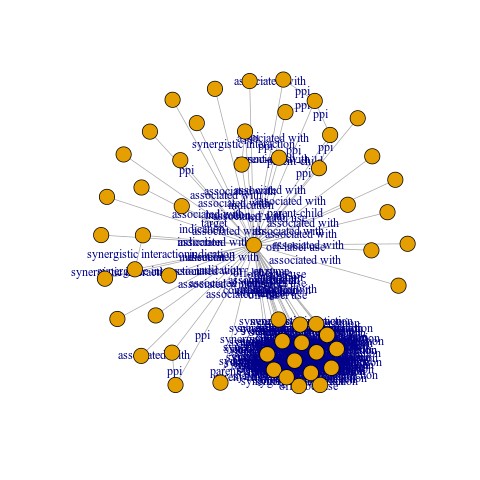

In [190]:
%%R
coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     # vertex.color =l[V(g)$name,],
     vertex.size=10,
     edge.label = d$display_relation
    )

___

### geneset!

In [18]:
gesa_res = pd.concat(dict([
    (treat, pd.read_excel('results/go_gsea.xlsx',index_col=0,header=0,sheet_name=f'CRISPRi {treat}')['es'])
    for treat in Ci_adata.comparisons.keys()
]),axis=1).fillna(0)

### PCC graph
Pearson’s correlation coefficient (PCC) `gene-gene-cor` graph

> #### A Genetic Map of the Response to DNA Damage in Human Cells
> The similarity in profiles of genes having related function (e.g.,
XRCC4 and LIG4 or ERCC6 and ERCC8) prompted us to undertake similarity profiling based on their Pearson correlation coefficient (PCC). This allowed us to build a network where genes are
nodes, and their edges are constrained by their PCC values

> - https://doi.org/10.1016/j.cell.2020.05.040


In [19]:
# exclude neg-ctrl signal
rho_df_1 = rho_df[~rho_df.index.str.contains('pseudo')].copy()

# exclude genes if they are non-hit in all screens
rho_df_2 = rho_df_1[~rho_label[~rho_df.index.str.contains('pseudo')].eq('target_non_hit').sum(axis=1).eq(9)].copy()

# get gene level corr values
rho_target_corr = rho_df_2.T.corr()
rho_target_corr.columns.name = None

In [20]:
# make the graph table
rho_target_corr_gr_table0 = rho_target_corr.reset_index().melt(
    id_vars=['target'],var_name=['target2']
)

<div class="alert alert-block alert-info"> <b>NOTE</b> `target` and `target2` are target genes from a single targeting CRISPR platform. These are just named for Pearson’s correlation coefficient (PCC) graph analysis. </div>

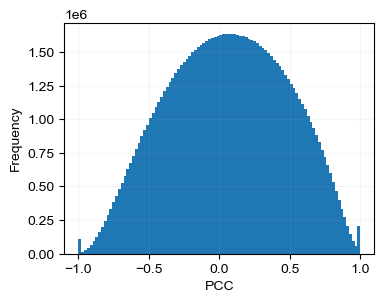

In [21]:
rho_target_corr_gr_table0.value.hist(bins=100,figsize=(4,3))
plt.xlabel('PCC')
plt.ylabel('Frequency')
plt.grid('off', alpha=0.1) 
plt.show() 

#### filter

In [22]:
rho_target_corr_gr_table = rho_target_corr_gr_table0.query("value > 0.9 & target != target2").reset_index(drop=True)

In [23]:
# rho_target_corr_gr_table.value.hist(bins=100,figsize=(4,3))
# plt.xlabel('PCC')
# plt.ylabel('Frequency')
# plt.grid('off', alpha=0.1) 
# plt.show() 

In [24]:
rho_target_corr_gr = build_graph(rho_target_corr_gr_table)

IGRAPH UNW- 10035 702798 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 10035
Number of edges in the graph 702798
Is the graph directed: False
Maximum degree in the graph: 13146
Node name with Maximum degree: ['ANLN', 'GAR1', 'NOP2', 'POLR2H', 'RPS13', 'UTP20']


In [25]:
help(filter_graph_by_weight)

Help on function filter_graph_by_weight in module search:

filter_graph_by_weight(G, weight_thr, side, verbose=True)
    subset graph by weight threshold



In [26]:
rho_target_corr_gr_prdx1 = filter_graph_by_geneset(
    rho_target_corr_gr,
    geneset=['PRDX1'],
    max_distance=1
)

IGRAPH UNW- 30 382 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 30
Number of edges in the graph 382
Is the graph directed: False
Maximum degree in the graph: 58
Node name with Maximum degree: ['PRDX1']


In [27]:
# plot_graph(
#     rho_target_corr_gr_prdx1.simplify(),
#     geneset=['PRDX1'],
#     # geneset2 = list(set(rho_phenotypes.vs['name']) - set(['ctrlcontext']) ),
#     layout='kk', b1=600,b2=450)

___

In [199]:
keep = rho_target_corr_gr_prdx1.vs['name']

In [288]:
d = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
d.columns = ['V1','V2','weight']

### PARPi

In [310]:
treat = 'PARPi+WEE1i'

In [311]:
s = rho_df.loc[keep,[treat]].fillna(0).abs()

In [312]:
l = rho_label.loc[keep,[treat]].replace({treat: {
    'target_non_hit': 'grey30', 
    'resistance_hit': '#de2d26', 
    'sensitivity_hit': "#3182bd", 
}}).astype(str)

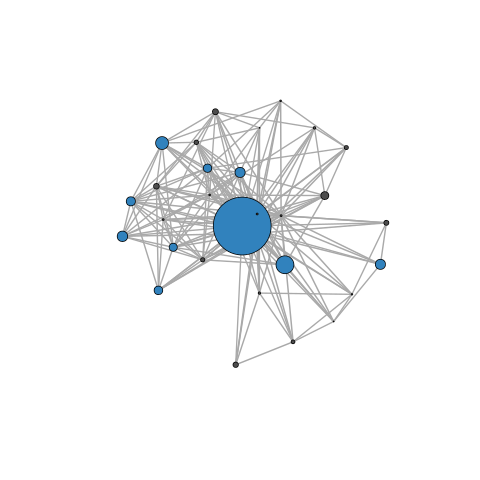

In [317]:
%%R -i d,s,l
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

V(g)$color <- l[V(g)$name,]
E(g)$width <- E(g)$weight 

coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     vertex.size=abs(s[V(g)$name,] * 20)
    )

In [293]:
%%R
is_weighted(g)

[1] TRUE


___

In [172]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [233]:
%%R
c2 = cluster_leading_eigen(g)

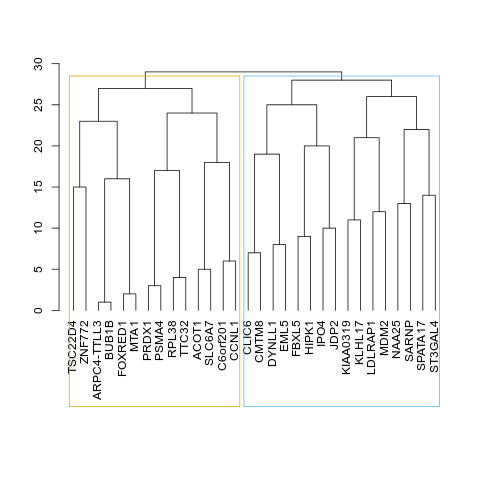

In [259]:
%%R
igraph::plot_dendrogram(c2)

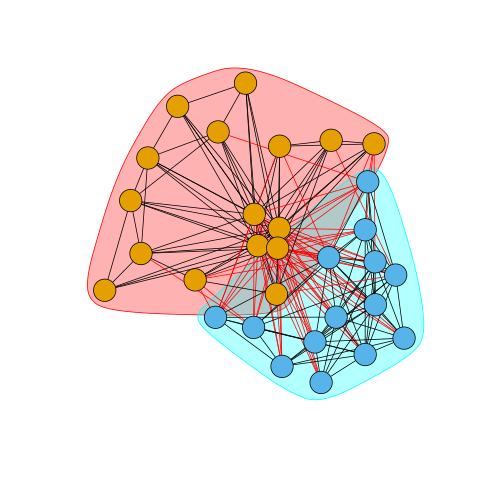

In [260]:
%%R 
plot(c2, g, 
     layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     # vertex.size=abs(s[V(g)$name,] * 20)
    )

### 
<!-- GTP graph -->
`Gene-Treatment-PhenotypeScore` wighted graph

___
build graph

In [ ]:
# gr_table = pd.concat([
#     rho_df.reset_index().melt(id_vars=['target'],value_name='score',var_name='treatment').set_index(['target','treatment']),
#     rho_label.reset_index().melt(id_vars=['target'],var_name='treatment',value_name='label').set_index(['target','treatment'])
# ],axis=1).query('label != "pseudo" and label != "target_non_hit"')

In [ ]:
# gr = build_graph(gr_table.drop(columns='label').reset_index())

___
combine

In [ ]:
# keep = rho_target_corr_gr_prdx1.vs['name']

In [ ]:
# d1 = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
# d1.columns = ['col_1','col_2','value']
# d1['edgeType'] = 'PCC'

# d2 = gr_table.drop(columns='label').reset_index().query(f'target in {keep}').reset_index(drop=True)
# d2.columns = ['col_1','col_2','value']
# d2['edgeType'] = 'GTP'

# d = pd.concat([d1,d2],axis=0).reset_index(drop=True)

In [ ]:
# %%R -i d

# d %>% head

In [ ]:
# %%R
# g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
# g = igraph::simplify(g)

In [ ]:
# %%R
# coords = layout_with_fr(g)
# # plot the graph
# plot(igraph::simplify(g), layout=coords, vertex.label=NA, vertex.size=10)

In [ ]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [ ]:
# %%R
# c2 = cluster_leading_eigen(g)

In [ ]:
# %%R
# igraph::plot_dendrogram(c2)

In [ ]:
# %%R 
# plot(c2, g, layout=coords, vertex.color=membership(c1),vertex.label=NA, vertex.size=10)

In [ ]:
# %%R
# plot(g, vertex.color=membership(c2), layout=coords)

# 

In [ ]:
%%R
sessionInfo()

In [19]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-08-03T13:09:50.628633-07:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
pandas: 2.0.3

